**Author:** [Riccardo Guidotti](http://kdd.isti.cnr.it/people/riccardo-guidotti)  
**Python version:**  3.x

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict

# Data Preparation

In [2]:
class_name = 'Occupancy'
df = pd.read_csv('occupancy_data/datatraining.txt', skipinitialspace=True, na_values='?', keep_default_na=True)
df.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


In [3]:
def daytime(h):
    if 6 <= h < 13:
        return 'morning'
    elif 13 <= h < 18:
        return 'afternoon'
    elif 18 <= h < 22:
        return 'evening'
    return 'night'

In [4]:
df['daytime'] = [daytime(d.hour) for d in pd.to_datetime(df['date'])]
df['weekend'] = [1 if d.weekday() >= 5 else 0 for d in pd.to_datetime(df['date'])]
columns2remove = ['date']
df.drop(columns2remove, inplace=True, axis=1)
df.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,daytime,weekend
1,23.18,27.2720,426.0,721.25,0.004793,1,afternoon,0
2,23.15,27.2675,429.5,714.00,0.004783,1,afternoon,0
3,23.15,27.2450,426.0,713.50,0.004779,1,afternoon,0
4,23.15,27.2000,426.0,708.25,0.004772,1,afternoon,0
5,23.10,27.2000,426.0,704.50,0.004757,1,afternoon,0


In [5]:
df0 = df.copy()

In [6]:
dfX = pd.get_dummies(df[[c for c in df.columns if c != class_name]], prefix_sep='=')
dfY = df[class_name]
df = pd.concat([dfX, dfY], axis=1)
df.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,weekend,daytime=afternoon,daytime=evening,daytime=morning,daytime=night,Occupancy
1,23.18,27.2720,426.0,721.25,0.004793,0,1,0,0,0,1
2,23.15,27.2675,429.5,714.00,0.004783,0,1,0,0,0,1
3,23.15,27.2450,426.0,713.50,0.004779,0,1,0,0,0,1
4,23.15,27.2000,426.0,708.25,0.004772,0,1,0,0,0,1
5,23.10,27.2000,426.0,704.50,0.004757,0,1,0,0,0,1


# Data Partitioning

In [7]:
from sklearn.model_selection import train_test_split, cross_val_score 

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [8]:
attributes = [col for col in df.columns if col != class_name]
X = df[attributes].values
y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

# Normalization

In [9]:
from sklearn.preprocessing import StandardScaler

In [10]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Sklearn Multilayer Perceptron

In [11]:
from sklearn.neural_network import MLPClassifier

### Parameters

hidden_layer_sizes tuple, length = n_layers - 2, default=(100,)
The ith element represents the number of neurons in the ith hidden layer.

activation {'identity', 'logistic', 'tanh', 'relu'}, default='relu'
Activation function for the hidden layer.
* 'identity', no-op activation, useful to implement linear bottleneck, returns f(x) = x
* 'logistic', the logistic sigmoid function, returns f(x) = 1 / (1 + exp(-x)).
* 'tanh', the hyperbolic tan function, returns f(x) = tanh(x).
* 'relu', the rectified linear unit function, returns f(x) = max(0, x)

solver {'lbfgs', 'sgd', 'adam'}, default='adam'
The solver for weight optimization.
* 'lbfgs' is an optimizer in the family of quasi-Newton methods.
* 'sgd' refers to stochastic gradient descent.
* 'adam' refers to a stochastic gradient-based optimizer proposed by Kingma, Diederik, and Jimmy Ba
The default solver 'adam' works pretty well on relatively large datasets (>= 1000 training samples) in terms of both training time and validation score. For small datasets, 'lbfgs' can converge faster and perform better.

alpha float, default=0.0001
L2 penalty (regularization term) parameter.

batch_size int, default='auto'
Size of minibatches for stochastic optimizers. If the solver is 'lbfgs', the classifier will not use minibatch. When set to “auto”, batch_size=min(200, n_samples)

learning_rate {'constant', 'invscaling', 'adaptive'}, default='constant'
Learning rate schedule for weight updates.
*'constant' is a constant learning rate given by 'learning_rate_init'.
*'invscaling' gradually decreases the learning rate at each time step 't' using an inverse scaling exponent of *'power_t'. effective_learning_rate = learning_rate_init / pow(t, power_t)
*'adaptive' keeps the learning rate constant to 'learning_rate_init' as long as training loss keeps decreasing. Each time two consecutive epochs fail to decrease training loss by at least tol, or fail to increase validation score by at least tol if 'early_stopping' is on, the current learning rate is divided by 5.
Only used when solver='sgd'.

learning_rate_init double, default=0.001
The initial learning rate used. It controls the step-size in updating the weights. Only used when solver='sgd' or 'adam'.

power_t double, default=0.5
The exponent for inverse scaling learning rate. It is used in updating effective learning rate when the learning_rate is set to 'invscaling'. Only used when solver='sgd'.

max_iter int, default=200
Maximum number of iterations. The solver iterates until convergence (determined by 'tol') or this number of iterations. For stochastic solvers ('sgd', 'adam'), note that this determines the number of epochs (how many times each data point will be used), not the number of gradient steps.

shuffle bool, default=True
Whether to shuffle samples in each iteration. Only used when solver='sgd' or 'adam'.

random_state int, RandomState instance or None, default=None
If int, random_state is the seed used by the random number generator; If RandomState instance, random_state is the random number generator; If None, the random number generator is the RandomState instance used by np.random.

tol float, default=1e-4
Tolerance for the optimization. When the loss or score is not improving by at least tol for n_iter_no_change consecutive iterations, unless learning_rate is set to 'adaptive', convergence is considered to be reached and training stops.

verbose bool, default=False
Whether to print progress messages to stdout.

warm_start bool, default=False
When set to True, reuse the solution of the previous call to fit as initialization, otherwise, just erase the previous solution. See the Glossary.

momentum float, default=0.9
Momentum for gradient descent update. Should be between 0 and 1. Only used when solver='sgd'.

early_stopping bool, default=False
Whether to use early stopping to terminate training when validation score is not improving. If set to true, it will automatically set aside 10% of training data as validation and terminate training when validation score is not improving by at least tol for n_iter_no_change consecutive epochs. The split is stratified, except in a multilabel setting. Only effective when solver='sgd' or 'adam'

validation_fraction float, default=0.1
The proportion of training data to set aside as validation set for early stopping. Must be between 0 and 1. Only used if early_stopping is True

beta_1 float, default=0.9
Exponential decay rate for estimates of first moment vector in adam, should be in [0, 1). Only used when solver='adam'

beta_2 float, default=0.999
Exponential decay rate for estimates of second moment vector in adam, should be in [0, 1). Only used when solver='adam'

epsilon float, default=1e-8
Value for numerical stability in adam. Only used when solver='adam'

n_iter_no_change int, default=10
Maximum number of epochs to not meet tol improvement. Only effective when solver='sgd' or 'adam'


### Attributes
loss_ float
The current loss computed with the loss function.

coefs_ list, length n_layers - 1
The ith element in the list represents the weight matrix corresponding to layer i.

intercepts_ list, length n_layers - 1
The ith element in the list represents the bias vector corresponding to layer i + 1.

n_iter_ int,
The number of iterations the solver has ran.

n_layers_ int
Number of layers.

n_outputs_ int
Number of outputs.

out_activation_ string
Name of the output activation function.

In [12]:
clf = MLPClassifier(random_state=0)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9930413426115432
F1-score [0.99557407 0.98373206]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1924
           1       0.98      0.99      0.98       519

    accuracy                           0.99      2443
   macro avg       0.99      0.99      0.99      2443
weighted avg       0.99      0.99      0.99      2443



/Users/riccardo/opt/miniconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


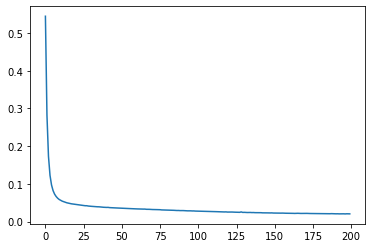

In [13]:
plt.plot(clf.loss_curve_)
plt.show()

In [14]:
clf = MLPClassifier(hidden_layer_sizes=(128, 64, 32,), alpha=0.1, learning_rate='adaptive', 
                    activation='tanh', early_stopping=False, momentum=0.9, random_state=0)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9897666803110929
F1-score [0.99350143 0.9759384 ]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1924
           1       0.97      0.98      0.98       519

    accuracy                           0.99      2443
   macro avg       0.98      0.99      0.98      2443
weighted avg       0.99      0.99      0.99      2443



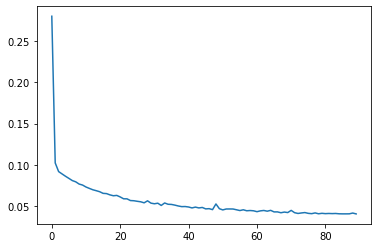

In [15]:
plt.plot(clf.loss_curve_)
plt.show()

In [16]:
params = [{'solver': 'sgd', 'learning_rate': 'constant', 'momentum': 0,'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'constant', 'momentum': .9,
           'nesterovs_momentum': False, 'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': 0,
           'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': .9,
           'nesterovs_momentum': False, 'learning_rate_init': 0.2},
          {'solver': 'adam', 'learning_rate_init': 0.01}]

labels = ["constant learning-rate", "constant with momentum",
          "inv-scaling learning-rate", "inv-scaling with momentum", "adam"]

In [17]:
import warnings
from sklearn.exceptions import ConvergenceWarning

constant learning-rate
training set score and loss: 0.788, 0.749526


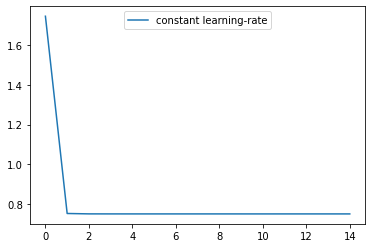

constant with momentum
training set score and loss: 0.788, 24.231273


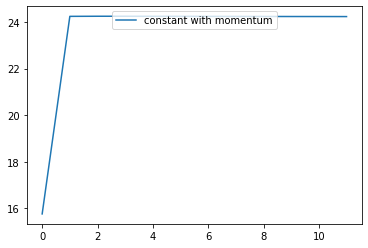

inv-scaling learning-rate
training set score and loss: 0.788, 0.754787


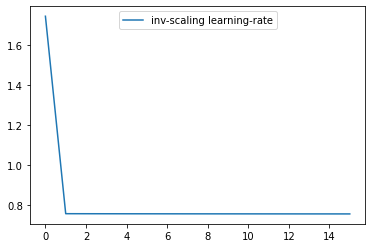

inv-scaling with momentum
training set score and loss: 0.788, 24.244236


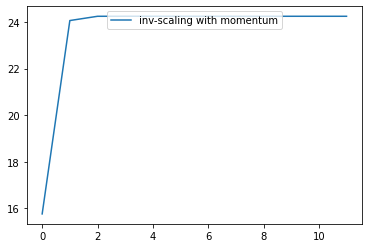

adam
training set score and loss: 0.989, 0.493000


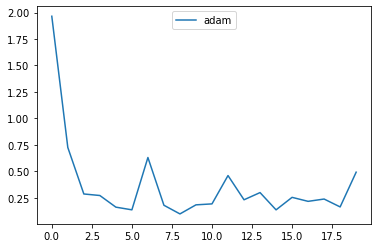

In [18]:
for label, param in zip(labels, params):
    print(label)
    clf = MLPClassifier(random_state=0, max_iter=200, **param)

    # some parameter combinations will not converge as can be seen on the
    # plots so they are ignored here
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
        clf.fit(X, y)

    print("training set score and loss: %.3f, %f" % (clf.score(X, y), clf.loss_))
    plt.plot(clf.loss_curve_, label=label)
    plt.legend(loc="upper center")
    plt.show()

# Keras Deep Neural Networks

In [19]:
from keras.models import Sequential
from keras.layers import Dense

In [20]:
def build_model():
    
    n_feature = X_train.shape[1]
    model = Sequential()
    model.add(Dense(128, input_dim=n_feature, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [21]:
model1 = build_model()

history1 = model1.fit(X_train, y_train, epochs=50, batch_size=10).history

Epoch 1/50
570/570 [==============================] - 1s 596us/step - loss: 0.1571 - accuracy: 0.9573
Epoch 2/50
570/570 [==============================] - 0s 577us/step - loss: 0.0412 - accuracy: 0.9868
Epoch 3/50
570/570 [==============================] - 0s 570us/step - loss: 0.0333 - accuracy: 0.9890
Epoch 4/50
570/570 [==============================] - 0s 604us/step - loss: 0.0340 - accuracy: 0.9889
Epoch 5/50
570/570 [==============================] - 0s 564us/step - loss: 0.0337 - accuracy: 0.9874
Epoch 6/50
570/570 [==============================] - 0s 582us/step - loss: 0.0296 - accuracy: 0.9898
Epoch 7/50
570/570 [==============================] - 0s 620us/step - loss: 0.0293 - accuracy: 0.9883
Epoch 8/50
570/570 [==============================] - 0s 564us/step - loss: 0.0370 - accuracy: 0.9859
Epoch 9/50
570/570 [==============================] - 0s 576us/step - loss: 0.0320 - accuracy: 0.9903
Epoch 10/50
570/570 [==============================] - 0s 570us/step - loss: 0.018

In [22]:
model2 = build_model()

history2 = model2.fit(X_train, y_train, epochs=50, batch_size=50).history

Epoch 1/50
114/114 [==============================] - 0s 711us/step - loss: 0.2738 - accuracy: 0.9239
Epoch 2/50
114/114 [==============================] - 0s 629us/step - loss: 0.0475 - accuracy: 0.9880
Epoch 3/50
114/114 [==============================] - 0s 708us/step - loss: 0.0392 - accuracy: 0.9885
Epoch 4/50
114/114 [==============================] - 0s 647us/step - loss: 0.0421 - accuracy: 0.9855
Epoch 5/50
114/114 [==============================] - 0s 663us/step - loss: 0.0380 - accuracy: 0.9871
Epoch 6/50
114/114 [==============================] - 0s 663us/step - loss: 0.0401 - accuracy: 0.9852
Epoch 7/50
114/114 [==============================] - 0s 720us/step - loss: 0.0339 - accuracy: 0.9878
Epoch 8/50
114/114 [==============================] - 0s 685us/step - loss: 0.0279 - accuracy: 0.9892
Epoch 9/50
114/114 [==============================] - 0s 635us/step - loss: 0.0310 - accuracy: 0.9887
Epoch 10/50
114/114 [==============================] - 0s 748us/step - loss: 0.028

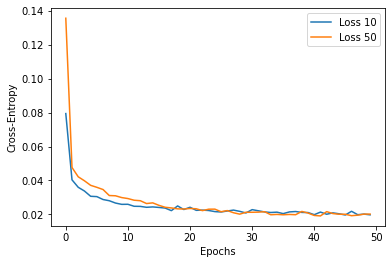

In [23]:
plt.plot(history1['loss'], label='Loss 10')
plt.plot(history2['loss'], label='Loss 50')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.show()

In [24]:
test_loss_1, test_acc_1 = model1.evaluate(X_test, y_test)
test_loss_2, test_acc_2 = model2.evaluate(X_test, y_test)

print('Loss %f, Accuracy %f' % (test_loss_1, test_acc_1))
print('Loss %f, Accuracy %f' % (test_loss_2, test_acc_2))

77/77 [==============================] - 0s 571us/step - loss: 0.0235 - accuracy: 0.9910
Loss 0.019907, Accuracy 0.993451
Loss 0.023489, Accuracy 0.990995


In [25]:
y_pred = model1.predict(X_test).astype(int)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.7920589439214081
F1-score [0.88337925 0.04150943]
              precision    recall  f1-score   support

           0       0.79      1.00      0.88      1924
           1       1.00      0.02      0.04       519

    accuracy                           0.79      2443
   macro avg       0.90      0.51      0.46      2443
weighted avg       0.84      0.79      0.70      2443



In [26]:
model3 = build_model()

history3 = model3.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1000, batch_size=10).history

Epoch 1/1000
570/570 [==============================] - 1s 2ms/step - loss: 0.1336 - accuracy: 0.9560 - val_loss: 0.0366 - val_accuracy: 0.9910
Epoch 2/1000
570/570 [==============================] - 0s 849us/step - loss: 0.0419 - accuracy: 0.9885 - val_loss: 0.0322 - val_accuracy: 0.9902
Epoch 3/1000
570/570 [==============================] - 0s 875us/step - loss: 0.0298 - accuracy: 0.9904 - val_loss: 0.0279 - val_accuracy: 0.9889
Epoch 4/1000
570/570 [==============================] - 0s 860us/step - loss: 0.0311 - accuracy: 0.9895 - val_loss: 0.0308 - val_accuracy: 0.9898
Epoch 5/1000
570/570 [==============================] - 0s 810us/step - loss: 0.0339 - accuracy: 0.9875 - val_loss: 0.0298 - val_accuracy: 0.9906
Epoch 6/1000
570/570 [==============================] - 0s 840us/step - loss: 0.0352 - accuracy: 0.9871 - val_loss: 0.0317 - val_accuracy: 0.9902
Epoch 7/1000
570/570 [==============================] - 0s 795us/step - loss: 0.0408 - accuracy: 0.9860 - val_loss: 0.0297 - v

Epoch 57/1000
570/570 [==============================] - 1s 878us/step - loss: 0.0234 - accuracy: 0.9931 - val_loss: 0.0199 - val_accuracy: 0.9922
Epoch 58/1000
570/570 [==============================] - 0s 803us/step - loss: 0.0202 - accuracy: 0.9937 - val_loss: 0.0248 - val_accuracy: 0.9914
Epoch 59/1000
570/570 [==============================] - 0s 764us/step - loss: 0.0130 - accuracy: 0.9960 - val_loss: 0.0235 - val_accuracy: 0.9902
Epoch 60/1000
570/570 [==============================] - 0s 809us/step - loss: 0.0192 - accuracy: 0.9923 - val_loss: 0.0201 - val_accuracy: 0.9922
Epoch 61/1000
570/570 [==============================] - 0s 817us/step - loss: 0.0218 - accuracy: 0.9929 - val_loss: 0.0264 - val_accuracy: 0.9910
Epoch 62/1000
570/570 [==============================] - 0s 797us/step - loss: 0.0178 - accuracy: 0.9938 - val_loss: 0.0223 - val_accuracy: 0.9918
Epoch 63/1000
570/570 [==============================] - 0s 843us/step - loss: 0.0198 - accuracy: 0.9940 - val_loss: 0

570/570 [==============================] - 0s 799us/step - loss: 0.0174 - accuracy: 0.9935 - val_loss: 0.0217 - val_accuracy: 0.9906
Epoch 113/1000
570/570 [==============================] - 0s 809us/step - loss: 0.0163 - accuracy: 0.9929 - val_loss: 0.0199 - val_accuracy: 0.9918
Epoch 114/1000
570/570 [==============================] - 0s 804us/step - loss: 0.0134 - accuracy: 0.9947 - val_loss: 0.0254 - val_accuracy: 0.9910
Epoch 115/1000
570/570 [==============================] - 0s 802us/step - loss: 0.0186 - accuracy: 0.9924 - val_loss: 0.0204 - val_accuracy: 0.9918
Epoch 116/1000
570/570 [==============================] - 0s 802us/step - loss: 0.0170 - accuracy: 0.9935 - val_loss: 0.0219 - val_accuracy: 0.9926
Epoch 117/1000
570/570 [==============================] - 0s 780us/step - loss: 0.0129 - accuracy: 0.9961 - val_loss: 0.0233 - val_accuracy: 0.9914
Epoch 118/1000
570/570 [==============================] - 0s 780us/step - loss: 0.0233 - accuracy: 0.9925 - val_loss: 0.0227 - 

570/570 [==============================] - 0s 874us/step - loss: 0.0203 - accuracy: 0.9939 - val_loss: 0.0222 - val_accuracy: 0.9914
Epoch 168/1000
570/570 [==============================] - 0s 866us/step - loss: 0.0165 - accuracy: 0.9938 - val_loss: 0.0200 - val_accuracy: 0.9922
Epoch 169/1000
570/570 [==============================] - 0s 875us/step - loss: 0.0164 - accuracy: 0.9936 - val_loss: 0.0200 - val_accuracy: 0.9914
Epoch 170/1000
570/570 [==============================] - 1s 947us/step - loss: 0.0110 - accuracy: 0.9962 - val_loss: 0.0201 - val_accuracy: 0.9914
Epoch 171/1000
570/570 [==============================] - 0s 797us/step - loss: 0.0146 - accuracy: 0.9945 - val_loss: 0.0186 - val_accuracy: 0.9906
Epoch 172/1000
570/570 [==============================] - 0s 834us/step - loss: 0.0156 - accuracy: 0.9926 - val_loss: 0.0201 - val_accuracy: 0.9906
Epoch 173/1000
570/570 [==============================] - 0s 824us/step - loss: 0.0152 - accuracy: 0.9943 - val_loss: 0.0197 - 

570/570 [==============================] - 0s 795us/step - loss: 0.0127 - accuracy: 0.9942 - val_loss: 0.0214 - val_accuracy: 0.9939
Epoch 223/1000
570/570 [==============================] - 0s 856us/step - loss: 0.0200 - accuracy: 0.9915 - val_loss: 0.0250 - val_accuracy: 0.9898
Epoch 224/1000
570/570 [==============================] - 0s 833us/step - loss: 0.0152 - accuracy: 0.9942 - val_loss: 0.0217 - val_accuracy: 0.9926
Epoch 225/1000
570/570 [==============================] - 0s 786us/step - loss: 0.0157 - accuracy: 0.9947 - val_loss: 0.0223 - val_accuracy: 0.9914
Epoch 226/1000
570/570 [==============================] - 0s 790us/step - loss: 0.0163 - accuracy: 0.9949 - val_loss: 0.0237 - val_accuracy: 0.9922
Epoch 227/1000
570/570 [==============================] - 0s 771us/step - loss: 0.0150 - accuracy: 0.9943 - val_loss: 0.0209 - val_accuracy: 0.9926
Epoch 228/1000
570/570 [==============================] - 0s 787us/step - loss: 0.0135 - accuracy: 0.9948 - val_loss: 0.0208 - 

570/570 [==============================] - 0s 774us/step - loss: 0.0108 - accuracy: 0.9954 - val_loss: 0.0233 - val_accuracy: 0.9926
Epoch 278/1000
570/570 [==============================] - 0s 759us/step - loss: 0.0128 - accuracy: 0.9954 - val_loss: 0.0263 - val_accuracy: 0.9894
Epoch 279/1000
570/570 [==============================] - 0s 773us/step - loss: 0.0157 - accuracy: 0.9929 - val_loss: 0.0208 - val_accuracy: 0.9935
Epoch 280/1000
570/570 [==============================] - 0s 835us/step - loss: 0.0095 - accuracy: 0.9969 - val_loss: 0.0194 - val_accuracy: 0.9935
Epoch 281/1000
570/570 [==============================] - 0s 838us/step - loss: 0.0141 - accuracy: 0.9951 - val_loss: 0.0232 - val_accuracy: 0.9918
Epoch 282/1000
570/570 [==============================] - 0s 772us/step - loss: 0.0115 - accuracy: 0.9963 - val_loss: 0.0243 - val_accuracy: 0.9914
Epoch 283/1000
570/570 [==============================] - 0s 779us/step - loss: 0.0134 - accuracy: 0.9956 - val_loss: 0.0208 - 

570/570 [==============================] - 0s 762us/step - loss: 0.0095 - accuracy: 0.9957 - val_loss: 0.0235 - val_accuracy: 0.9906
Epoch 333/1000
570/570 [==============================] - 0s 788us/step - loss: 0.0158 - accuracy: 0.9934 - val_loss: 0.0237 - val_accuracy: 0.9910
Epoch 334/1000
570/570 [==============================] - 0s 810us/step - loss: 0.0084 - accuracy: 0.9975 - val_loss: 0.0218 - val_accuracy: 0.9918
Epoch 335/1000
570/570 [==============================] - 0s 767us/step - loss: 0.0144 - accuracy: 0.9947 - val_loss: 0.0217 - val_accuracy: 0.9930
Epoch 336/1000
570/570 [==============================] - 0s 799us/step - loss: 0.0102 - accuracy: 0.9963 - val_loss: 0.0251 - val_accuracy: 0.9918
Epoch 337/1000
570/570 [==============================] - 0s 786us/step - loss: 0.0136 - accuracy: 0.9953 - val_loss: 0.0231 - val_accuracy: 0.9922
Epoch 338/1000
570/570 [==============================] - 0s 772us/step - loss: 0.0119 - accuracy: 0.9959 - val_loss: 0.0231 - 

570/570 [==============================] - 0s 829us/step - loss: 0.0103 - accuracy: 0.9969 - val_loss: 0.0307 - val_accuracy: 0.9918
Epoch 388/1000
570/570 [==============================] - 0s 768us/step - loss: 0.0124 - accuracy: 0.9956 - val_loss: 0.0302 - val_accuracy: 0.9918
Epoch 389/1000
570/570 [==============================] - 0s 761us/step - loss: 0.0137 - accuracy: 0.9958 - val_loss: 0.0371 - val_accuracy: 0.9906
Epoch 390/1000
570/570 [==============================] - 0s 758us/step - loss: 0.0189 - accuracy: 0.9943 - val_loss: 0.0302 - val_accuracy: 0.9914
Epoch 391/1000
570/570 [==============================] - 0s 762us/step - loss: 0.0124 - accuracy: 0.9959 - val_loss: 0.0307 - val_accuracy: 0.9922
Epoch 392/1000
570/570 [==============================] - 0s 759us/step - loss: 0.0101 - accuracy: 0.9968 - val_loss: 0.0376 - val_accuracy: 0.9918
Epoch 393/1000
570/570 [==============================] - 0s 761us/step - loss: 0.0165 - accuracy: 0.9939 - val_loss: 0.0333 - 

570/570 [==============================] - 0s 793us/step - loss: 0.0129 - accuracy: 0.9951 - val_loss: 0.0290 - val_accuracy: 0.9922
Epoch 443/1000
570/570 [==============================] - 0s 794us/step - loss: 0.0100 - accuracy: 0.9959 - val_loss: 0.0247 - val_accuracy: 0.9922
Epoch 444/1000
570/570 [==============================] - 0s 793us/step - loss: 0.0129 - accuracy: 0.9948 - val_loss: 0.0234 - val_accuracy: 0.9935
Epoch 445/1000
570/570 [==============================] - 0s 782us/step - loss: 0.0121 - accuracy: 0.9963 - val_loss: 0.0281 - val_accuracy: 0.9918
Epoch 446/1000
570/570 [==============================] - 0s 877us/step - loss: 0.0118 - accuracy: 0.9957 - val_loss: 0.0256 - val_accuracy: 0.9910
Epoch 447/1000
570/570 [==============================] - 1s 957us/step - loss: 0.0160 - accuracy: 0.9937 - val_loss: 0.0213 - val_accuracy: 0.9930
Epoch 448/1000
570/570 [==============================] - 1s 1ms/step - loss: 0.0116 - accuracy: 0.9955 - val_loss: 0.0256 - va

570/570 [==============================] - 1s 948us/step - loss: 0.0120 - accuracy: 0.9954 - val_loss: 0.0238 - val_accuracy: 0.9922
Epoch 498/1000
570/570 [==============================] - 0s 846us/step - loss: 0.0119 - accuracy: 0.9957 - val_loss: 0.0259 - val_accuracy: 0.9935
Epoch 499/1000
570/570 [==============================] - 0s 816us/step - loss: 0.0117 - accuracy: 0.9965 - val_loss: 0.0301 - val_accuracy: 0.9926
Epoch 500/1000
570/570 [==============================] - 0s 804us/step - loss: 0.0094 - accuracy: 0.9963 - val_loss: 0.0250 - val_accuracy: 0.9935
Epoch 501/1000
570/570 [==============================] - 0s 830us/step - loss: 0.0122 - accuracy: 0.9959 - val_loss: 0.0289 - val_accuracy: 0.9930
Epoch 502/1000
570/570 [==============================] - 0s 809us/step - loss: 0.0184 - accuracy: 0.9954 - val_loss: 0.0291 - val_accuracy: 0.9910
Epoch 503/1000
570/570 [==============================] - 0s 795us/step - loss: 0.0159 - accuracy: 0.9939 - val_loss: 0.0298 - 

570/570 [==============================] - 0s 776us/step - loss: 0.0163 - accuracy: 0.9951 - val_loss: 0.0186 - val_accuracy: 0.9947
Epoch 553/1000
570/570 [==============================] - 0s 753us/step - loss: 0.0117 - accuracy: 0.9964 - val_loss: 0.0247 - val_accuracy: 0.9922
Epoch 554/1000
570/570 [==============================] - 0s 764us/step - loss: 0.0119 - accuracy: 0.9959 - val_loss: 0.0241 - val_accuracy: 0.9922
Epoch 555/1000
570/570 [==============================] - 0s 752us/step - loss: 0.0130 - accuracy: 0.9953 - val_loss: 0.0228 - val_accuracy: 0.9930
Epoch 556/1000
570/570 [==============================] - 0s 771us/step - loss: 0.0127 - accuracy: 0.9955 - val_loss: 0.0275 - val_accuracy: 0.9922
Epoch 557/1000
570/570 [==============================] - 0s 767us/step - loss: 0.0127 - accuracy: 0.9950 - val_loss: 0.0234 - val_accuracy: 0.9926
Epoch 558/1000
570/570 [==============================] - 1s 924us/step - loss: 0.0105 - accuracy: 0.9959 - val_loss: 0.0251 - 

570/570 [==============================] - 0s 798us/step - loss: 0.0106 - accuracy: 0.9972 - val_loss: 0.0275 - val_accuracy: 0.9918
Epoch 608/1000
570/570 [==============================] - 0s 788us/step - loss: 0.0150 - accuracy: 0.9948 - val_loss: 0.0230 - val_accuracy: 0.9943
Epoch 609/1000
570/570 [==============================] - 0s 760us/step - loss: 0.0125 - accuracy: 0.9953 - val_loss: 0.0231 - val_accuracy: 0.9926
Epoch 610/1000
570/570 [==============================] - 1s 958us/step - loss: 0.0118 - accuracy: 0.9963 - val_loss: 0.0243 - val_accuracy: 0.9939
Epoch 611/1000
570/570 [==============================] - 0s 824us/step - loss: 0.0103 - accuracy: 0.9963 - val_loss: 0.0227 - val_accuracy: 0.9943
Epoch 612/1000
570/570 [==============================] - 0s 772us/step - loss: 0.0111 - accuracy: 0.9959 - val_loss: 0.0204 - val_accuracy: 0.9926
Epoch 613/1000
570/570 [==============================] - 0s 874us/step - loss: 0.0107 - accuracy: 0.9962 - val_loss: 0.0253 - 

570/570 [==============================] - 0s 806us/step - loss: 0.0099 - accuracy: 0.9955 - val_loss: 0.0298 - val_accuracy: 0.9930
Epoch 663/1000
570/570 [==============================] - 0s 793us/step - loss: 0.0156 - accuracy: 0.9951 - val_loss: 0.0225 - val_accuracy: 0.9939
Epoch 664/1000
570/570 [==============================] - 0s 797us/step - loss: 0.0082 - accuracy: 0.9973 - val_loss: 0.0245 - val_accuracy: 0.9922
Epoch 665/1000
570/570 [==============================] - 1s 1ms/step - loss: 0.0101 - accuracy: 0.9964 - val_loss: 0.0274 - val_accuracy: 0.9914
Epoch 666/1000
570/570 [==============================] - 1s 906us/step - loss: 0.0124 - accuracy: 0.9954 - val_loss: 0.0275 - val_accuracy: 0.9926
Epoch 667/1000
570/570 [==============================] - 0s 774us/step - loss: 0.0113 - accuracy: 0.9955 - val_loss: 0.0267 - val_accuracy: 0.9935
Epoch 668/1000
570/570 [==============================] - 0s 745us/step - loss: 0.0096 - accuracy: 0.9959 - val_loss: 0.0249 - va

570/570 [==============================] - 0s 819us/step - loss: 0.0095 - accuracy: 0.9971 - val_loss: 0.0298 - val_accuracy: 0.9922
Epoch 718/1000
570/570 [==============================] - 0s 856us/step - loss: 0.0099 - accuracy: 0.9966 - val_loss: 0.0313 - val_accuracy: 0.9935
Epoch 719/1000
570/570 [==============================] - 0s 844us/step - loss: 0.0088 - accuracy: 0.9976 - val_loss: 0.0413 - val_accuracy: 0.9894
Epoch 720/1000
570/570 [==============================] - 0s 860us/step - loss: 0.0147 - accuracy: 0.9953 - val_loss: 0.0289 - val_accuracy: 0.9914
Epoch 721/1000
570/570 [==============================] - 0s 872us/step - loss: 0.0126 - accuracy: 0.9944 - val_loss: 0.0231 - val_accuracy: 0.9935
Epoch 722/1000
570/570 [==============================] - 0s 841us/step - loss: 0.0165 - accuracy: 0.9940 - val_loss: 0.0250 - val_accuracy: 0.9939
Epoch 723/1000
570/570 [==============================] - 0s 811us/step - loss: 0.0101 - accuracy: 0.9968 - val_loss: 0.0294 - 

570/570 [==============================] - 0s 754us/step - loss: 0.0107 - accuracy: 0.9957 - val_loss: 0.0371 - val_accuracy: 0.9926
Epoch 773/1000
570/570 [==============================] - 0s 786us/step - loss: 0.0142 - accuracy: 0.9957 - val_loss: 0.0244 - val_accuracy: 0.9922
Epoch 774/1000
570/570 [==============================] - 0s 786us/step - loss: 0.0075 - accuracy: 0.9975 - val_loss: 0.0272 - val_accuracy: 0.9943
Epoch 775/1000
570/570 [==============================] - 0s 763us/step - loss: 0.0102 - accuracy: 0.9968 - val_loss: 0.0318 - val_accuracy: 0.9910
Epoch 776/1000
570/570 [==============================] - 0s 766us/step - loss: 0.0128 - accuracy: 0.9943 - val_loss: 0.0261 - val_accuracy: 0.9922
Epoch 777/1000
570/570 [==============================] - 0s 754us/step - loss: 0.0092 - accuracy: 0.9966 - val_loss: 0.0275 - val_accuracy: 0.9918
Epoch 778/1000
570/570 [==============================] - 0s 803us/step - loss: 0.0122 - accuracy: 0.9961 - val_loss: 0.0331 - 

570/570 [==============================] - 0s 786us/step - loss: 0.0089 - accuracy: 0.9966 - val_loss: 0.0299 - val_accuracy: 0.9935
Epoch 828/1000
570/570 [==============================] - 0s 835us/step - loss: 0.0084 - accuracy: 0.9977 - val_loss: 0.0324 - val_accuracy: 0.9926
Epoch 829/1000
570/570 [==============================] - 0s 815us/step - loss: 0.0103 - accuracy: 0.9954 - val_loss: 0.0262 - val_accuracy: 0.9935
Epoch 830/1000
570/570 [==============================] - 0s 777us/step - loss: 0.0085 - accuracy: 0.9964 - val_loss: 0.0297 - val_accuracy: 0.9918
Epoch 831/1000
570/570 [==============================] - 0s 788us/step - loss: 0.0125 - accuracy: 0.9929 - val_loss: 0.0273 - val_accuracy: 0.9930
Epoch 832/1000
570/570 [==============================] - 0s 809us/step - loss: 0.0094 - accuracy: 0.9962 - val_loss: 0.0281 - val_accuracy: 0.9918
Epoch 833/1000
570/570 [==============================] - 0s 787us/step - loss: 0.0119 - accuracy: 0.9947 - val_loss: 0.0235 - 

570/570 [==============================] - 0s 777us/step - loss: 0.0087 - accuracy: 0.9967 - val_loss: 0.0341 - val_accuracy: 0.9926
Epoch 883/1000
570/570 [==============================] - 0s 868us/step - loss: 0.0108 - accuracy: 0.9963 - val_loss: 0.0289 - val_accuracy: 0.9935
Epoch 884/1000
570/570 [==============================] - 0s 817us/step - loss: 0.0101 - accuracy: 0.9958 - val_loss: 0.0369 - val_accuracy: 0.9930
Epoch 885/1000
570/570 [==============================] - 0s 838us/step - loss: 0.0077 - accuracy: 0.9968 - val_loss: 0.0240 - val_accuracy: 0.9947
Epoch 886/1000
570/570 [==============================] - 0s 818us/step - loss: 0.0136 - accuracy: 0.9950 - val_loss: 0.0283 - val_accuracy: 0.9930
Epoch 887/1000
570/570 [==============================] - 0s 812us/step - loss: 0.0098 - accuracy: 0.9961 - val_loss: 0.0308 - val_accuracy: 0.9935
Epoch 888/1000
570/570 [==============================] - 0s 777us/step - loss: 0.0090 - accuracy: 0.9970 - val_loss: 0.0255 - 

570/570 [==============================] - 0s 755us/step - loss: 0.0069 - accuracy: 0.9981 - val_loss: 0.0278 - val_accuracy: 0.9930
Epoch 938/1000
570/570 [==============================] - 0s 751us/step - loss: 0.0098 - accuracy: 0.9961 - val_loss: 0.0375 - val_accuracy: 0.9935
Epoch 939/1000
570/570 [==============================] - 0s 742us/step - loss: 0.0076 - accuracy: 0.9978 - val_loss: 0.0307 - val_accuracy: 0.9939
Epoch 940/1000
570/570 [==============================] - 0s 776us/step - loss: 0.0076 - accuracy: 0.9979 - val_loss: 0.0381 - val_accuracy: 0.9914
Epoch 941/1000
570/570 [==============================] - 0s 739us/step - loss: 0.0101 - accuracy: 0.9967 - val_loss: 0.0271 - val_accuracy: 0.9947
Epoch 942/1000
570/570 [==============================] - 0s 741us/step - loss: 0.0112 - accuracy: 0.9941 - val_loss: 0.0360 - val_accuracy: 0.9926
Epoch 943/1000
570/570 [==============================] - 0s 741us/step - loss: 0.0105 - accuracy: 0.9958 - val_loss: 0.0376 - 

570/570 [==============================] - 0s 781us/step - loss: 0.0084 - accuracy: 0.9968 - val_loss: 0.0315 - val_accuracy: 0.9939
Epoch 993/1000
570/570 [==============================] - 0s 734us/step - loss: 0.0097 - accuracy: 0.9960 - val_loss: 0.0324 - val_accuracy: 0.9930
Epoch 994/1000
570/570 [==============================] - 0s 738us/step - loss: 0.0090 - accuracy: 0.9970 - val_loss: 0.0336 - val_accuracy: 0.9943
Epoch 995/1000
570/570 [==============================] - 0s 731us/step - loss: 0.0103 - accuracy: 0.9957 - val_loss: 0.0293 - val_accuracy: 0.9943
Epoch 996/1000
570/570 [==============================] - 0s 733us/step - loss: 0.0125 - accuracy: 0.9953 - val_loss: 0.0400 - val_accuracy: 0.9906
Epoch 997/1000
570/570 [==============================] - 0s 747us/step - loss: 0.0113 - accuracy: 0.9947 - val_loss: 0.0367 - val_accuracy: 0.9930
Epoch 998/1000
570/570 [==============================] - 0s 735us/step - loss: 0.0083 - accuracy: 0.9974 - val_loss: 0.0328 - 

In [27]:
test_loss_3, test_acc_3 = model3.evaluate(X_test, y_test)

print('Loss %f, Accuracy %f' % (test_loss_1, test_acc_1))
print('Loss %f, Accuracy %f' % (test_loss_2, test_acc_2))
print('Loss %f, Accuracy %f' % (test_loss_3, test_acc_3))

77/77 [==============================] - 0s 495us/step - loss: 0.0371 - accuracy: 0.9935
Loss 0.019907, Accuracy 0.993451
Loss 0.023489, Accuracy 0.990995
Loss 0.037080, Accuracy 0.993451


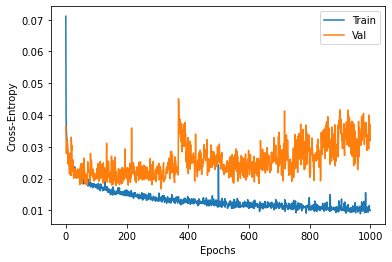

In [28]:
plt.plot(history3['loss'], label='Train')
plt.plot(history3['val_loss'], label='Val')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.show()

In [29]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

## Early Stopping

In [30]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

The most relevant arguments are:

* monitor: quantity to be monitored
* patience: number of epochs with no improvement after which training will be stopped

In [31]:
es = EarlyStopping(monitor='val_loss', patience=10)
mc = ModelCheckpoint('best_model_NOREG.h5', monitor='val_loss', save_best_only=True)

model4 = build_model()
history4 = model4.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, 
                      batch_size=10, callbacks=[es,mc]).history

Epoch 1/100
456/456 [==============================] - 1s 890us/step - loss: 0.1544 - accuracy: 0.9726 - val_loss: 0.0547 - val_accuracy: 0.9877
Epoch 2/100
456/456 [==============================] - 0s 698us/step - loss: 0.0395 - accuracy: 0.9872 - val_loss: 0.0506 - val_accuracy: 0.9851
Epoch 3/100
456/456 [==============================] - 0s 699us/step - loss: 0.0351 - accuracy: 0.9894 - val_loss: 0.0554 - val_accuracy: 0.9877
Epoch 4/100
456/456 [==============================] - 0s 700us/step - loss: 0.0300 - accuracy: 0.9893 - val_loss: 0.0524 - val_accuracy: 0.9868
Epoch 5/100
456/456 [==============================] - 0s 723us/step - loss: 0.0432 - accuracy: 0.9846 - val_loss: 0.0505 - val_accuracy: 0.9877
Epoch 6/100
456/456 [==============================] - 0s 694us/step - loss: 0.0305 - accuracy: 0.9886 - val_loss: 0.0481 - val_accuracy: 0.9833
Epoch 7/100
456/456 [==============================] - 0s 715us/step - loss: 0.0469 - accuracy: 0.9811 - val_loss: 0.0479 - val_ac

In [32]:
test_loss_4, test_acc_4 = model4.evaluate(X_test, y_test)

print('Loss %f, Accuracy %f' % (test_loss_1, test_acc_1))
print('Loss %f, Accuracy %f' % (test_loss_2, test_acc_2))
print('Loss %f, Accuracy %f' % (test_loss_3, test_acc_3))
print('Loss %f, Accuracy %f' % (test_loss_4, test_acc_4))

77/77 [==============================] - 0s 711us/step - loss: 0.0240 - accuracy: 0.9918
Loss 0.019907, Accuracy 0.993451
Loss 0.023489, Accuracy 0.990995
Loss 0.037080, Accuracy 0.993451
Loss 0.023965, Accuracy 0.991813


## L2 Regularization

In [33]:
from keras.regularizers import l2

def build_L2_model():
    # define the model
    model = Sequential()

    n_feature = X_train.shape[1]
    h_dim=100
    model.add(Dense(h_dim, activation='relu', input_shape=(n_feature,), kernel_regularizer=l2(0.01)))
    model.add(Dense(h_dim, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dense(h_dim, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dense(h_dim, activation='relu', kernel_regularizer=l2(0.01)))
    #linear activation
    model.add(Dense(1))

    #compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [34]:
mc = ModelCheckpoint('best_model_L2.h5', monitor='val_loss', save_best_only=True)

L2_model = build_L2_model()
h_L2 = L2_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, 
                    batch_size=10, callbacks=[es,mc]).history

Epoch 1/100
456/456 [==============================] - 1s 1ms/step - loss: 1.9445 - accuracy: 0.9588 - val_loss: 0.6915 - val_accuracy: 0.9868
Epoch 2/100
456/456 [==============================] - 0s 891us/step - loss: 0.6475 - accuracy: 0.9811 - val_loss: 3.5075 - val_accuracy: 0.7947
Epoch 3/100
456/456 [==============================] - 0s 873us/step - loss: 3.6886 - accuracy: 0.7811 - val_loss: 3.4074 - val_accuracy: 0.7947
Epoch 4/100
456/456 [==============================] - 0s 1ms/step - loss: 3.3960 - accuracy: 0.7943 - val_loss: 3.3412 - val_accuracy: 0.7947
Epoch 5/100
456/456 [==============================] - 1s 1ms/step - loss: 3.5314 - accuracy: 0.7815 - val_loss: 3.2921 - val_accuracy: 0.7947
Epoch 6/100
456/456 [==============================] - 0s 902us/step - loss: 3.3989 - accuracy: 0.7872 - val_loss: 3.2550 - val_accuracy: 0.7947
Epoch 7/100
456/456 [==============================] - 0s 818us/step - loss: 3.4372 - accuracy: 0.7824 - val_loss: 3.2272 - val_accuracy

In [35]:
from keras.layers import Dropout

def build_DROPOUT_model():
    # define the model
    model = Sequential()

    n_feature = X_train.shape[1]
    h_dim=100
    model.add(Dense(h_dim, activation='relu', input_shape=(n_feature,)))
    model.add(Dropout(0.2))
    model.add(Dense(h_dim, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(h_dim, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(h_dim, activation='relu'))
    #linear activation
    model.add(Dense(1))

    #compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [36]:
mc = ModelCheckpoint('best_model_DROPOUT.h5', monitor='val_loss', save_best_only=True)

DROPOUT_model = build_DROPOUT_model()
h_DROPOUT = DROPOUT_model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                              epochs=100, batch_size=10, callbacks=[es,mc]).history

Epoch 1/100
456/456 [==============================] - 1s 1ms/step - loss: 0.1792 - accuracy: 0.9688 - val_loss: 0.1889 - val_accuracy: 0.9868
Epoch 2/100
456/456 [==============================] - 0s 1ms/step - loss: 0.1725 - accuracy: 0.9858 - val_loss: 0.1873 - val_accuracy: 0.9877
Epoch 3/100
456/456 [==============================] - 0s 880us/step - loss: 0.1920 - accuracy: 0.9868 - val_loss: 0.2446 - val_accuracy: 0.9825
Epoch 4/100
456/456 [==============================] - 0s 904us/step - loss: 0.1951 - accuracy: 0.9859 - val_loss: 0.2162 - val_accuracy: 0.9851
Epoch 5/100
456/456 [==============================] - 0s 826us/step - loss: 0.2282 - accuracy: 0.9837 - val_loss: 0.1874 - val_accuracy: 0.9877
Epoch 6/100
456/456 [==============================] - 1s 1ms/step - loss: 0.1856 - accuracy: 0.9878 - val_loss: 0.1873 - val_accuracy: 0.9877
Epoch 7/100
456/456 [==============================] - 0s 1ms/step - loss: 0.1981 - accuracy: 0.9866 - val_loss: 0.1880 - val_accuracy: 

In [37]:
# laod best models and test them
from keras.models import load_model

best_NOREG_model = load_model('best_model_NOREG.h5')
best_L2_model = load_model('best_model_L2.h5')
best_DROPOUT_model = load_model('best_model_DROPOUT.h5')

loss_NOREG, acc_NOREG = best_NOREG_model.evaluate(X_test, y_test)
loss_L2, acc_L2 = best_L2_model.evaluate(X_test, y_test)
loss_DROPOUT, acc_DROPOUT = best_DROPOUT_model.evaluate(X_test, y_test)

77/77 [==============================] - 0s 488us/step - loss: 0.1382 - accuracy: 0.9906


In [38]:
print('Loss %f, Accuracy %f' % (loss_NOREG, acc_NOREG))
print('Loss %f, Accuracy %f' % (loss_L2, acc_L2))
print('Loss %f, Accuracy %f' % (loss_DROPOUT, acc_DROPOUT))

Loss 0.021535, Accuracy 0.992223
Loss 0.634186, Accuracy 0.990995
Loss 0.138231, Accuracy 0.990585


## Hyper-Parameter Tuning

In [39]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV

In [40]:
def build_model(n_layers=2, h_dim=64, activation='relu', optimizer='adam'):
    # define the model
    model = Sequential()

    n_feature = X_train.shape[1]
    
    model.add(Dense(h_dim, activation=activation, input_shape=(n_feature,)))
    for i in range(n_layers-1):
        model.add(Dense(h_dim, activation=activation))
    #linear activation
    model.add(Dense(1))

    #compile the model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

In [41]:
n_layers = [1, 2, 3]
h_dim = [32, 64, 128]
activation = ['relu', 'tanh']
optimizer = ['adagrad', 'adam']
params = dict(optimizer=optimizer, n_layers=n_layers, h_dim=h_dim, activation=activation)

In [42]:
model = KerasRegressor(build_fn=build_model)

rnd = RandomizedSearchCV(estimator=model, param_distributions=params, n_iter=5, cv=3)
rnd_result = rnd.fit(X_train, y_train, epochs=100, batch_size=10, verbose=0)

48/48 [==============================] - 0s 479us/step - loss: 0.1812 - accuracy: 0.9875


In [43]:
print("Best: %f using %s" % (-rnd_result.best_score_, rnd_result.best_params_))
means = rnd_result.cv_results_['mean_test_score']
stds = rnd_result.cv_results_['std_test_score']
params = rnd_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (-mean, stdev, param))

Best: 0.104686 using {'optimizer': 'adagrad', 'n_layers': 2, 'h_dim': 128, 'activation': 'tanh'}
0.104686 (0.044461) with: {'optimizer': 'adagrad', 'n_layers': 2, 'h_dim': 128, 'activation': 'tanh'}
0.458918 (0.556023) with: {'optimizer': 'adagrad', 'n_layers': 2, 'h_dim': 32, 'activation': 'tanh'}
0.629233 (0.790657) with: {'optimizer': 'adagrad', 'n_layers': 1, 'h_dim': 32, 'activation': 'relu'}
0.187738 (0.016946) with: {'optimizer': 'adam', 'n_layers': 3, 'h_dim': 128, 'activation': 'tanh'}
0.157399 (0.023955) with: {'optimizer': 'adam', 'n_layers': 1, 'h_dim': 64, 'activation': 'tanh'}


In [44]:
clf = rnd_result.best_estimator_.model

loss, acc = clf.evaluate(X_test, y_test)
print('Loss %f, Accuracy %f' % (loss, acc))

77/77 [==============================] - 0s 473us/step - loss: 0.0757 - accuracy: 0.9885
Loss 0.075692, Accuracy 0.988539
